In [20]:
import pandas as pd
import numpy as np
import string
import warnings
import math
import nltk
import json
from langdetect import detect
from libsvm import *
from nltk.stem import PorterStemmer
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV
from IPython.display import display

from scipy.sparse import csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm
import dask.dataframe as dd
import multiprocessing
import swifter
warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('words')
from spellchecker import SpellChecker

spell = SpellChecker()

# pd.set_option('display.max_colwidth', None)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/anishajauhari/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [21]:
rock_pop_dataset = pd.read_csv("../../data/rockpopdataset.csv")

In [22]:
rock_pop_dataset = rock_pop_dataset[rock_pop_dataset['filtered_lyrics'].notnull()]

In [23]:
rock_pop_dataset

,Unnamed: 0,song,year,artist,genre,lyrics,filtered_lyrics
0,0,ego remix,2009-01-01,beyonce knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut...",oh baby know im gonna cut right chase women ma...
1,1,then tell me,2009-01-01,beyonce knowles,Pop,"playin' everything so easy, it's like you seem...",playin everything easy like seem sure still wa...
2,2,honesty,2009-01-01,beyonce knowles,Pop,If you search For tenderness It isn't hard to ...,search tenderness isnt hard find love need liv...
3,3,you are my rock,2009-01-01,beyonce knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a...",oh oh oh oh oh oh verse wrote book stand titl...
4,4,black culture,2009-01-01,beyonce knowles,Pop,"Party the people, the people the party it's po...",party people people party popping sitting arou...
...,...,...,...,...,...,...,...
125539,198485,photographs you are taking now,2014-01-01,damon albarn,Pop,When the photographs you're taking now Are tak...,photographs youre taking taken heavy clouds hi...
125540,198486,you and me,2014-01-01,damon albarn,Pop,"I met Moko jumbie, He walks on stilts through ...",met moko jumbie walks stilts saints row lookin...
125541,198487,hollow ponds,2014-01-01,damon albarn,Pop,Chill on the hollow ponds Set sail by a kid In...,chill hollow ponds set sail kid heat wave hit ...
125542,198488,the selfish giant,2014-01-01,damon albarn,Pop,Celebrate the passing drugs Put them on the ba...,celebrate passing drugs put back seat theyre c...


### Additional features for Experiment 2

In [24]:
### Counting the misspelled words in lyrics
rock_pop_dataset["misspelled_words"] = rock_pop_dataset["filtered_lyrics"].apply(lambda x : len(spell.unknown(x.split())))

In [25]:
### Counting the number of unique words in lyrics
rock_pop_dataset["unique_words"] = rock_pop_dataset["filtered_lyrics"].apply(lambda x : len(set(x.split())))

In [26]:
### Counting the slang word occurences
SMS_SLANGS = {"ain't":"is not","aren't":"are not","can't":"cannot","can't've":"cannot have",
          "'cause":"because","could've":"could have","couldn't":"could not","couldn't've":"could not have",
          "didn't":"did not","doesn't":"does not","don't":"do not","hadn't":"had not","hadn't've":"had not have",
          "hasn't":"has not","haven't":"have not","he'd":"he would","he'd've":"he would have","he'll":"he will",
          "he'll've":"he he will have","he's":"he is","how'd":"how did","how'd'y":"how do you","how'll":"how will",
          "how's":"how is","I'd":"I would","I'd've":"I would have","I'll":"I will","I'll've":"I will have","I'm":"I am",
          "I've":"I have","i'd":"i would","i'd've":"i would have","i'll":"i will","i'll've":"i will have","i'm":"i am",
          "i've":"i have","isn't":"is not","it'd":"it would","it'd've":"it would have","it'll":"it will","it'll've":"it will have",
          "it's":"it is","let's":"let us","ma'am":"madam","mayn't":"may not","might've":"might have",
          "mightn't":"might not","mightn't've":"might not have","must've":"must have","mustn't":"must not","mustn't've":"must not have",
          "needn't":"need not","needn't've":"need not have","o'clock":"of the clock","oughtn't":"ought not","oughtn't've":"ought not have",
          "shan't":"shall not","sha'n't":"shall not","shan't've":"shall not have","she'd":"she would","she'd've":"she would have",
          "she'll":"she will","she'll've":"she will have","she's":"she is","should've":"should have","shouldn't":"should not",
          "shouldn't've":"should not have","so've":"so have","so's":"so as","that'd":"that would","that'd've":"that would have",
          "that's":"that is","there'd":"there would","there'd've":"there would have","there's":"there is","they'd":"they would",
          "they'd've":"they would have","they'll":"they will","they'll've":"they will have","they're":"they are","they've":"they have",
          "to've":"to have","wasn't":"was not","we'd":"we would","we'd've":"we would have","we'll":"we will","we'll've":"we will have",
          "we're":"we are","we've":"we have","weren't":"were not","what'll":"what will","what'll've":"what will have",
          "what're":"what are","what's":"what is","what've":"what have","when's":"when is","when've":"when have",
          "where'd":"where did","where's":"where is","where've":"where have","who'll":"who will","who'll've":"who will have",
          "who's":"who is","who've":"who have","why's":"why is","why've":"why have","will've":"will have","won't":"will not",
          "won't've":"will not have","would've":"would have","wouldn't":"would not","wouldn't've":"would not have","y'all":"you all",
          "y'all'd":"you all would","y'all'd've":"you all would have","y'all're":"you all are","y'all've":"you all have",
          "you'd":"you would","you'd've":"you would have","you'll":"you will","you'll've":"you will have",
          "you're":"you are","you've":"you have"}

with open('../../data/ShortendText.json','r') as file:
    abbr_dict=json.loads(file.read())
abbr_dict.update(SMS_SLANGS)
list_of_terms = abbr_dict.keys()

rock_pop_dataset["slang_words"] = rock_pop_dataset["filtered_lyrics"].apply(lambda x : len(set(list_of_terms)&set(x.split())))


In [27]:
##### Adding Audio Features #########
audio_features = pd.read_csv("../../data/audiofeatures")
audio_features["features"] = audio_features["features"].apply(lambda x: list(eval(x))[0])
audio_features_2 = pd.json_normalize(audio_features["features"])
# audio_features_2["title"] = audio_features["title"]
# audio_features_2["artist"] = audio_features["artist"]
# audio_features_2["genre"] = audio_features["genre"]
# audio_features = audio_features_2
audio_features = pd.merge(audio_features, audio_features_2, how="inner", right_index=True, left_index=True) 
audio_features = audio_features.drop(columns=["Unnamed: 0", "features"])

In [28]:
final_dataset = pd.merge(rock_pop_dataset, audio_features, how="left", left_on=["song", "artist", "genre"], right_on = ["title", "artist", "genre"])
final_dataset = final_dataset.loc[:, ["song", "year", "artist", "genre", "filtered_lyrics", "misspelled_words", "unique_words", "slang_words", 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]

In [29]:
final_dataset = final_dataset.fillna(0)

In [30]:
final_dataset

,song,year,artist,genre,filtered_lyrics,misspelled_words,unique_words,slang_words,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,ego remix,2009-01-01,beyonce knowles,Pop,oh baby know im gonna cut right chase women ma...,0,95,3,0.574,0.421,1.0,-5.443,1.0,0.174,0.0989,0.0,0.0568,0.341,78.781,283933.0
1,then tell me,2009-01-01,beyonce knowles,Pop,playin everything easy like seem sure still wa...,0,78,5,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
2,honesty,2009-01-01,beyonce knowles,Pop,search tenderness isnt hard find love need liv...,0,63,2,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
3,you are my rock,2009-01-01,beyonce knowles,Pop,oh oh oh oh oh oh verse wrote book stand titl...,0,83,4,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
4,black culture,2009-01-01,beyonce knowles,Pop,party people people party popping sitting arou...,1,27,1,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125546,photographs you are taking now,2014-01-01,damon albarn,Pop,photographs youre taking taken heavy clouds hi...,1,59,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125547,you and me,2014-01-01,damon albarn,Pop,met moko jumbie walks stilts saints row lookin...,4,66,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125548,hollow ponds,2014-01-01,damon albarn,Pop,chill hollow ponds set sail kid heat wave hit ...,0,36,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125549,the selfish giant,2014-01-01,damon albarn,Pop,celebrate passing drugs put back seat theyre c...,1,45,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0


In [31]:
final_dataset.to_csv("../../data/rockpopdataset_exp2.csv")

In [32]:
#### read ig files and add these features to that and then scale them. 

In [33]:
tf_idf_500 = pd.read_csv("../../data/tfidf_500")
ig_500 = pd.read_csv("../../data/ig_500")

In [34]:
tf_idf_500.set_index("index").drop(columns=["Unnamed: 0"])

,across,afraid,ah,aint,air,alive,alone,along,alright,always,...,ya,yeah,years,yes,yet,youd,youll,young,youre,youve
index,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.0,0.051316,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.035959,0.0,0.0,0.0,0.017066,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.069106,0.071415,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.036272,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.134267,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.049519,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.501332,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.106202,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125539,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.108537,0.0
125540,0.019609,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.012638,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
125541,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0


In [35]:
ig_500.set_index("index").drop(columns=["Unnamed: 0"])

,aa,ab,abe,aby,actin,age,ah,aint,ak,ake,...,yea,yeah,yes,yo,yonce,you,youre,yr,yu,zappa
index,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0
125540,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
125541,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
final_dataset.columns

Index(['song', 'year', 'artist', 'genre', 'filtered_lyrics',
       'misspelled_words', 'unique_words', 'slang_words', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms'],
      dtype='object')

In [37]:
features = final_dataset.loc[:, ['misspelled_words', 'unique_words', 'slang_words', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
features_2 = final_dataset.loc[:, ['misspelled_words', 'unique_words', 'slang_words', 'speechiness', 'acousticness',
       'instrumentalness']]

In [38]:
features

,misspelled_words,unique_words,slang_words,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0,95,3,0.574,0.421,1.0,-5.443,1.0,0.174,0.0989,0.0,0.0568,0.341,78.781,283933.0
1,0,78,5,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
2,0,63,2,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
3,0,83,4,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
4,1,27,1,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125546,1,59,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125547,4,66,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125548,0,36,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0
125549,1,45,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,0.0,0.0000,0.000,0.000,0.0


In [39]:
features_new = pd.merge(features, tf_idf_500, right_index = True, left_index= True, how="inner")
features_new_2 = pd.merge(features_2, tf_idf_500, right_index = True, left_index= True, how="inner")

In [40]:
features_new

,misspelled_words,unique_words,slang_words,danceability,energy,key,loudness,mode,speechiness,acousticness,...,yeah,years,yes,yet,youd,youll,young,youre,youve,index
0,0,95,3,0.574,0.421,1.0,-5.443,1.0,0.174,0.0989,...,0.0,0.0,0.0,0.035959,0.0,0.0,0.0,0.017066,0.0,0
1,0,78,5,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.036272,0.0,1
2,0,63,2,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.049519,0.0,2
3,0,83,4,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.106202,0.0,3
4,1,27,1,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125539,1,53,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.108537,0.0,125539
125540,1,20,1,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,125540
125541,0,27,0,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,125541
125542,0,32,1,0.000,0.000,0.0,0.000,0.0,0.000,0.0000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,125542


In [41]:
features_new.to_csv("../../data/features_expt_2.csv")
features_new_2.to_csv("../../data/features_expt_2_withpearson.csv")

In [42]:
features_new_ig = pd.merge(features, ig_500, right_index = True, left_index= True, how="inner")
features_new_ig_2 = pd.merge(features_2, ig_500, right_index = True, left_index= True, how="inner")

In [45]:
features_new_ig.to_csv("../../data/features_expt_2_ig.csv")
features_new_ig_2.to_csv("../../data/features_expt_2_ig_withpearson.csv")

<AxesSubplot:>

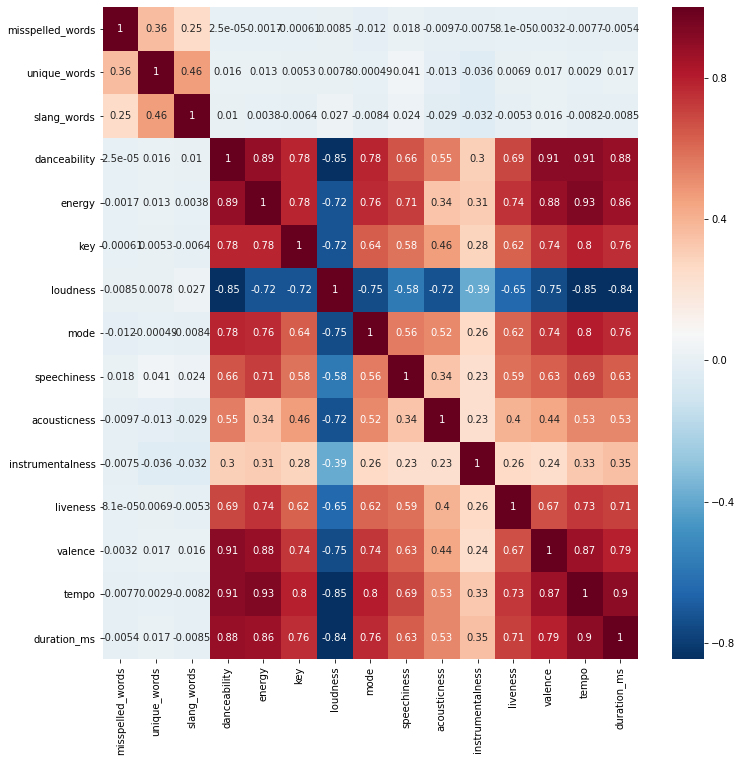

In [44]:
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,12)) 
features_new = pd.read_csv("../../data/features_expt_2.csv")
pearsoncorr = features_new.loc[:, ['misspelled_words', 'unique_words', 'slang_words', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']].corr(method="pearson")
sb.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0., 
              ax= ax)